[ 40.  50.  60.  68.  68.  78.  78.  89.  89. 100. 119. 140. 100. 119.
 140. 166. 195. 195. 235. 280. 337. 402.]


100%|██████████| 50/50 [00:35<00:00,  1.40it/s]


[[ 1.53050766 20.53029085 -2.87462405  1.00940987]
 [ 1.54068623 20.59797154 -2.77570626  1.01903718]
 [ 1.52410688 20.60700664 -2.8862687   1.00151066]
 [ 1.52842831 20.72861782 -2.9153492   0.99995427]
 [ 1.57605283 18.79948775 -2.94101179  1.00226663]
 [ 1.53098114 20.3535221  -2.85808127  1.00187616]
 [ 1.53388534 20.29323486 -2.96308404  1.00082528]
 [ 1.54221789 19.92867358 -3.04397062  0.99989263]
 [ 1.56517001 19.22233795 -2.79001284  0.9991179 ]
 [ 1.57849231 18.78319368 -2.79052304  0.99940263]
 [ 1.52397821 20.56415005 -2.78768577  1.00164295]
 [ 1.53263638 20.63073813 -2.90908411  0.99391699]
 [ 1.54520274 19.80231299 -2.86095477  1.00002144]
 [ 1.58340829 19.27792692 -2.92783265  0.986071  ]
 [ 1.53843471 20.12894426 -2.84178015  1.00320747]
 [ 1.5520279  19.63795701 -2.99834343  1.00070903]
 [ 1.54596566 20.05086899 -2.89277291  0.99989699]
 [ 1.52568824 20.61291336 -2.93097874  1.00015286]
 [ 1.54407955 19.93145579 -2.92147015  0.99978529]
 [ 1.52669313 20.46258664 -2.68

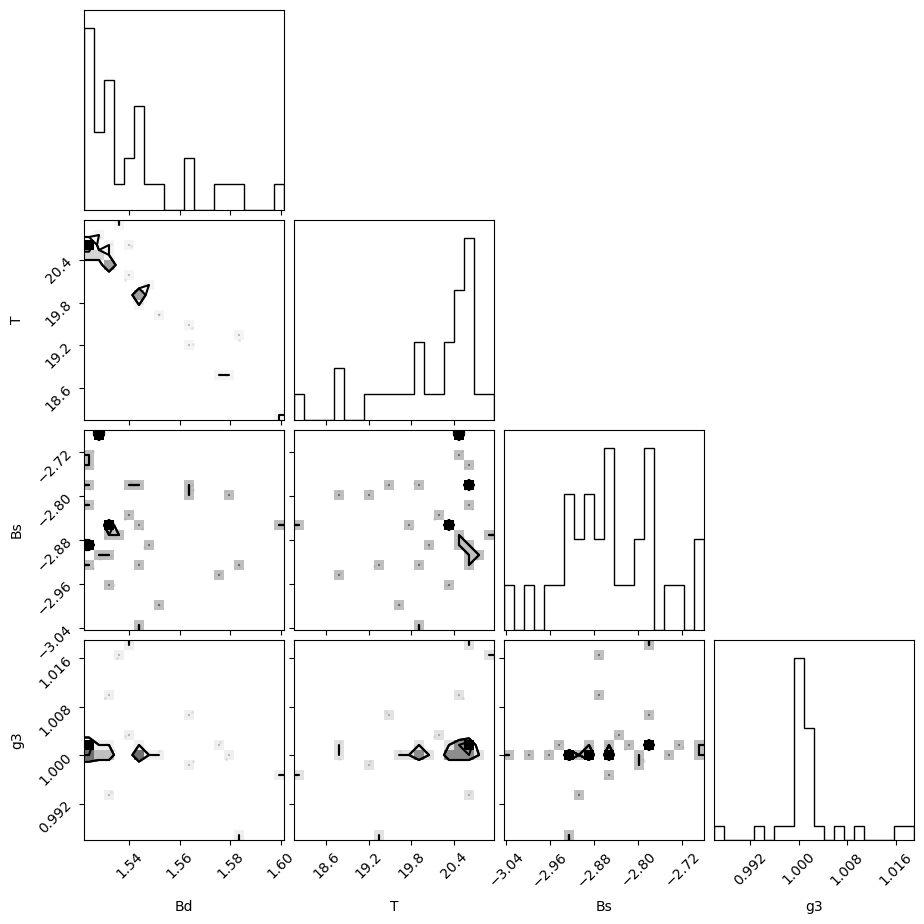

In [43]:
import warnings
warnings.filterwarnings("ignore")

import pysm3
import pysm3.units as u
from astropy import units as u
import pysm3.units as u
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from fgbuster import CMB, Dust, Synchrotron, MixingMatrix
from fgbuster.observation_helpers import standardize_instrument, get_observation,  get_instrument
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import emcee
import corner


instr = np.load('/Users/alicepirotta/Desktop/APC/FgBuster/instrument_LB_IMOv1.npy', allow_pickle=True).item()
instr_ = {}
instr_['frequency'] = np.array([instr[f]['freq'] for f in instr.keys()])
instr_['depth_p'] = np.array([instr[f]['P_sens'] for f in instr.keys()])
instr_['fwhm'] = np.array([instr[f]['beam'] for f in instr.keys()])
instr_['depth_i'] = instr_['depth_p']/np.sqrt(2)
instrument = standardize_instrument(instr_)
print(instr_['frequency'])



nside = 64
freq_mapsQ = get_observation(instrument, 'd0s0',nside=nside)[:,1,:]
freq_mapsU = get_observation(instrument, 'd0s0',nside=nside)[:,2,:]
freq_maps = get_observation(instrument, 'd0s0',nside=nside)
freq_mapsP = np.sqrt(np.power(freq_mapsQ,2)+np.power(freq_mapsU,2))

components= [CMB(),Dust(50.),Synchrotron(50.)]
A = MixingMatrix(*components)
A_ev = A.evaluator(instrument.frequency)

invN=np.linalg.inv(np.eye(len(instrument.frequency)))

x0 =np.array([1.54,20,-3,1,1,1])

def lnprior(i):
    Bd, Td, Bs, z = i
    if ((Bd < 0) or (Bd > 2) or
        (Td < 10) or (Td > 30) or
        (Bs < -4) or (Bs > -2) or 
        (z < 0)):
        return -np.inf
    else:
        return 0.0
    
def likelihood(i):
    Bd, T, Bs, z= i
    x, y = 1, 1
    G = np.diag([x,x,x,x,x,x,x,x,x,x,x,x,y,y,y,y,y,z,z,z,z,z])
    invNd = np.einsum('ij,jsp->isp', invN, freq_maps)
    A_maxL =G.dot(A_ev(np.array([Bd,T,Bs]))) 
    logL = 0
    AtNd= np.einsum('ji,jsp->isp', A_maxL, invNd)
    AtNA = np.linalg.inv(A_maxL.T.dot(invN).dot(A_maxL))
    logL = logL + np.einsum('isp,ij,jsp->', AtNd, AtNA, AtNd)
    if logL != logL:
        return 0.0
    return logL

def lnprob(x):
    lp = lnprior(x)
    return lp + likelihood(x)


ndim,nwalkers=4,30
pos = np.random.uniform(low=[x0[0] * (1 - 1 / 4), x0[1] * (1 - 1 / 4), x0[2] * (1 - 1 / 4), x0[3] * (1 - 1 / 4)], high=[x0[0] * (1 + 1 / 4), x0[1] * (1 + 1 / 4), x0[2] * (1 + 1 / 4), x0[3] * (1 + 1 / 4)], size=(nwalkers, ndim))


sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob)
sampler.run_mcmc(pos,50, progress=True)
samples = sampler.get_chain(flat=True)
flat_samples = sampler.get_chain(discard=25, thin=15, flat=True)
fig = corner.corner(flat_samples, labels=["Bd", "T", "Bs", "g3"])
print(flat_samples)
plt.show()




[[[ 1.212149   24.36793307 -3.41189137  1.07656971]
  [ 1.68417331 21.35588771 -3.39692572  1.02102375]
  [ 1.52523967 21.88860579 -3.50047369  1.11014601]
  ...
  [ 1.58441786 18.53168804 -2.33844187  1.05772843]
  [ 1.40724396 23.40909349 -3.56449961  1.10194567]
  [ 1.66375081 21.2942771  -2.6241646   1.21962226]]

 [[ 1.212149   24.36793307 -3.41189137  1.07656971]
  [ 1.68417331 21.35588771 -3.39692572  1.02102375]
  [ 1.52523967 21.88860579 -3.50047369  1.11014601]
  ...
  [ 1.58441786 18.53168804 -2.33844187  1.05772843]
  [ 1.46847051 20.99982249 -3.29513661  1.05719639]
  [ 1.66375081 21.2942771  -2.6241646   1.21962226]]

 [[ 1.21438313 24.33514835 -3.40608578  1.07534775]
  [ 1.67853454 21.33887667 -3.18356187  1.07585796]
  [ 1.52523967 21.88860579 -3.50047369  1.11014601]
  ...
  [ 1.58441786 18.53168804 -2.33844187  1.05772843]
  [ 1.46847051 20.99982249 -3.29513661  1.05719639]
  [ 1.66375081 21.2942771  -2.6241646   1.21962226]]

 ...

 [[ 1.52774958 20.48522424 -2.9075

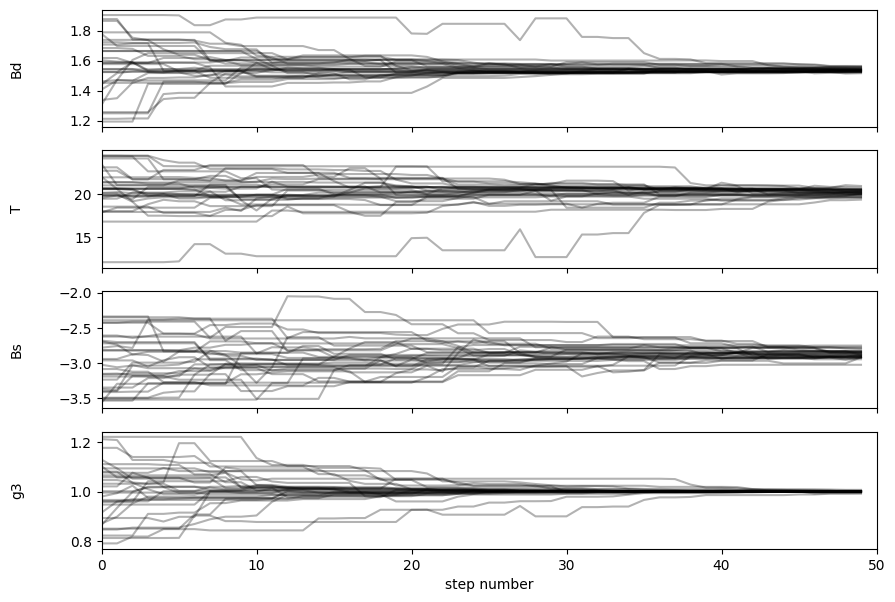

In [44]:
fig, axes = plt.subplots(4, figsize=(10, 7), sharex=True)
samples = sampler.get_chain()
print(samples)
labels = ["Bd", "T", "Bs", "g3"]
for i in range(ndim):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)
    ax.set_xlim(0, len(samples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1, 0.5)

axes[-1].set_xlabel("step number");

<function matplotlib.pyplot.show(close=None, block=None)>

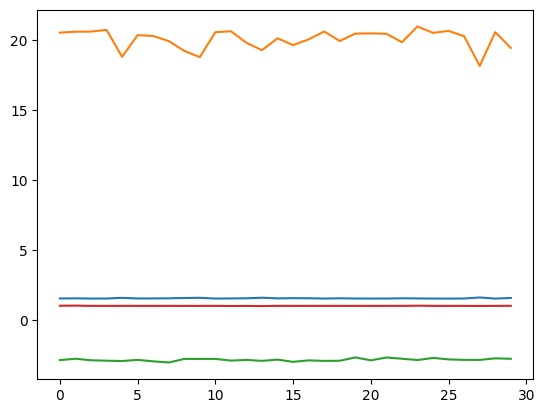

In [45]:
plt.plot(flat_samples)
plt.show